In [1]:
import os
import random
import re
import string

import nltk
import numpy as np
import pandas as pd

from gensim.models import Word2Vec

from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df_raw = pd.read_csv("dataset/articles_data.csv")

In [3]:
df_raw.head()

,Unnamed: 0,source_id,source_name,author,title,description,url,url_to_image,published_at,content,top_article,engagement_reaction_count,engagement_comment_count,engagement_share_count,engagement_comment_plugin_count
0,0,reuters,Reuters,Reuters Editorial,NTSB says Autopilot engaged in 2018 California...,The National Transportation Safety Board said ...,https://www.reuters.com/article/us-tesla-crash...,https://s4.reutersmedia.net/resources/r/?m=02&...,2019-09-03T16:22:20Z,WASHINGTON (Reuters) - The National Transporta...,0.0,0.0,0.0,2528.0,0.0
1,1,the-irish-times,The Irish Times,Eoin Burke-Kennedy,Unemployment falls to post-crash low of 5.2%,Latest monthly figures reflect continued growt...,https://www.irishtimes.com/business/economy/un...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T10:32:28Z,The States jobless rate fell to 5.2 per cent l...,0.0,6.0,10.0,2.0,0.0
2,2,the-irish-times,The Irish Times,Deirdre McQuillan,"Louise Kennedy AW2019: Long coats, sparkling t...",Autumn-winter collection features designer’s g...,https://www.irishtimes.com/\t\t\t\t\t\t\t/life...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T14:40:00Z,Louise Kennedy is showing off her autumn-winte...,1.0,NaN,NaN,NaN,NaN
3,3,al-jazeera-english,Al Jazeera English,Al Jazeera,North Korean footballer Han joins Italian gian...,Han is the first North Korean player in the Se...,https://www.aljazeera.com/news/2019/09/north-k...,https://www.aljazeera.com/mritems/Images/2019/...,2019-09-03T17:25:39Z,"Han Kwang Song, the first North Korean footbal...",0.0,0.0,0.0,7.0,0.0
4,4,bbc-news,BBC News,BBC News,UK government lawyer says proroguing parliamen...,"The UK government's lawyer, David Johnston arg...",https://www.bbc.co.uk/news/av/uk-scotland-4956...,https://ichef.bbci.co.uk/news/1024/branded_new...,2019-09-03T14:39:21Z,NaN,0.0,0.0,0.0,0.0,0.0


## Data preprocessing

In [4]:
def preprocess_text(corpus):
    """Pre-process corpus and generate tokens

    Args:
        corpus: corpus to tokenize.

    Returns:
        Tokenized corpus.
    """
    corpus = str(corpus).lower()  # Lowercase words
    corpus = re.sub(r"\[(.*?)\]", "", corpus)  # Remove [+XYZ chars] in content
    corpus = re.sub(r"\s+", " ", corpus)  # Remove multiple spaces in content
    corpus = re.sub(r"\w+…|…", "", corpus)  # Remove ellipsis (and last word)
    corpus = re.sub(r"(?<=\w)-(?=\w)", " ", corpus)  # Replace dash between words
    corpus = re.sub(f"[{re.escape(string.punctuation)}]", "", corpus)  # Remove punctuation

    tokens = word_tokenize(corpus)  # Get tokens from text
    custom_stopwords = set(stopwords.words("english") + ["news", "new", "top"])
    tokens = [t for t in tokens if not t in custom_stopwords]  # Remove stopwords
    tokens = ["" if t.isdigit() else t for t in tokens]  # Remove digits
    tokenized_corpus = [t for t in tokens if len(t) > 1]  # Remove short tokens
    return tokenized_corpus

In [5]:
text_columns = ["title", "description", "content"]

df = df_raw.copy()
df["content"] = df["content"].fillna("")

df["content"]

0        WASHINGTON (Reuters) - The National Transporta...
1        The States jobless rate fell to 5.2 per cent l...
2        Louise Kennedy is showing off her autumn-winte...
3        Han Kwang Song, the first North Korean footbal...
4                                                         
                               ...                        
10432    Growth in the U.S. economys vast services sect...
10433    ZURICH/HONG KONG (Reuters) - The announcement ...
10434                                                     
10435                                                     
10436                                                     
Name: content, Length: 10437, dtype: object

In [6]:
for col in text_columns:
    df[col] = df[col].astype(str)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10437 entries, 0 to 10436
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       10437 non-null  int64  
 1   source_id                        10437 non-null  object 
 2   source_name                      10437 non-null  object 
 3   author                           9417 non-null   object 
 4   title                            10437 non-null  object 
 5   description                      10437 non-null  object 
 6   url                              10436 non-null  object 
 7   url_to_image                     9781 non-null   object 
 8   published_at                     10436 non-null  object 
 9   content                          10437 non-null  object 
 10  top_article                      10435 non-null  float64
 11  engagement_reaction_count        10319 non-null  float64
 12  engagement_comment

In [7]:
# Create article column based on title, description, and content
df["article"] = df[text_columns].apply(lambda x: " | ".join(x), axis=1)
df["article"]

0        NTSB says Autopilot engaged in 2018 California...
1        Unemployment falls to post-crash low of 5.2% |...
2        Louise Kennedy AW2019: Long coats, sparkling t...
3        North Korean footballer Han joins Italian gian...
4        UK government lawyer says proroguing parliamen...
                               ...                        
10432    Drop in US service sector activity raises econ...
10433    Banker defections pose challenge for Credit Su...
10434    A 5-year-old cancer survivor donates 3,000 toy...
10435    Fateful Connection | A detective is haunted by...
10436    Love, Hate & Obsession | Who wanted one-time m...
Name: article, Length: 10437, dtype: object

In [8]:
df["tokenized_article"] = df["article"].map(lambda x: preprocess_text(x))
df["tokenized_article"]

0        [ntsb, says, autopilot, engaged, california, t...
1        [unemployment, falls, post, crash, low, latest...
2        [louise, kennedy, aw2019, long, coats, sparkli...
3        [north, korean, footballer, han, joins, italia...
4        [uk, government, lawyer, says, proroguing, par...
                               ...                        
10432    [drop, us, service, sector, activity, raises, ...
10433    [banker, defections, pose, challenge, credit, ...
10434    [year, old, cancer, survivor, donates, toys, c...
10435    [fateful, connection, detective, haunted, case...
10436    [love, hate, obsession, wanted, one, time, mil...
Name: tokenized_article, Length: 10437, dtype: object

In [9]:
# Remove duplicated after preprocessing
_, idx = np.unique(df["tokenized_article"], return_index=True)
df = df.iloc[idx, :]

# Remove empty values
df = df.loc[df.tokenized_article.map(lambda x: len(x) > 0), ["article", "tokenized_article"]]

print(f"Original data: {df_raw.shape}")
print(f"Pre-processed data: {df.shape}")

Original data: (10437, 15)
Pre-processed data: (9882, 2)


In [10]:
df["tokenized_article"]

8155     [12th, man, arrested, statutory, rape, case, a...
350      [18th, century, paris, apartment, elegantly, b...
8041     [19th, century, home, brooklyn, gets, 21st, ce...
4742     [1xtras, dj, ace, needs, kidney, dj, presenter...
1071     [2nd, person, us, dies, lung, disease, linked,...
                               ...                        
7162     [zinedine, zidane, long, real, madrid, lose, p...
8319     [zuckerberg, says, breaking, tech, firms, make...
10336    [zverev, tsitsipas, roll, beijing, quarters, s...
154      [â€˜genocide, cardâ€™, myanmar, rohingya, veri...
7392     [€500000, taken, estate, dead, man, without, e...
Name: tokenized_article, Length: 9882, dtype: object

## looking at vocabulary

In [11]:
from collections import Counter 

In [12]:
docs = df["article"].values
tokenized_docs = df["tokenized_article"].values

vocab = Counter()
for token in tokenized_docs:
    vocab.update(token)

In [13]:
vocab.most_common(8)

[('us', 2757),
 ('said', 2519),
 ('year', 1781),
 ('president', 1756),
 ('trump', 1705),
 ('world', 1620),
 ('says', 1511),
 ('one', 1418)]

## Vectorization using word embeddings

In [14]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

In [15]:
model = Word2Vec(sentences=tokenized_docs, vector_size=100, workers=1, seed=42)

In [16]:
model.wv.most_similar("president")

[('trump', 0.9746480584144592),
 ('trumps', 0.9707880616188049),
 ('ivanka', 0.9537523984909058),
 ('pences', 0.9508886933326721),
 ('impeachment', 0.9464113116264343),
 ('vice', 0.9433464407920837),
 ('donald', 0.9389464259147644),
 ('biden', 0.9375095367431641),
 ('ukraine', 0.9372271299362183),
 ('administration', 0.93710857629776)]

In [17]:
vectorized_docs = vectorize(tokenized_docs, model=model)
len(vectorized_docs), len(vectorized_docs[0])

(9882, 100)

## Finding the optimal number of clusters

In [18]:
def mbkmeans_clusters(X, k, mb=500, print_silhouette_values=False):
    """Generate clusters.

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches. Defaults to 500.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_


For n_clusters = 5 The average silhouette_score is : 0.23575298
For n_clusters = 6 The average silhouette_score is : 0.27466267
For n_clusters = 7 The average silhouette_score is : 0.25501722
For n_clusters = 8 The average silhouette_score is : 0.19206016
For n_clusters = 9 The average silhouette_score is : 0.17802669
For n_clusters = 10 The average silhouette_score is : 0.18370208


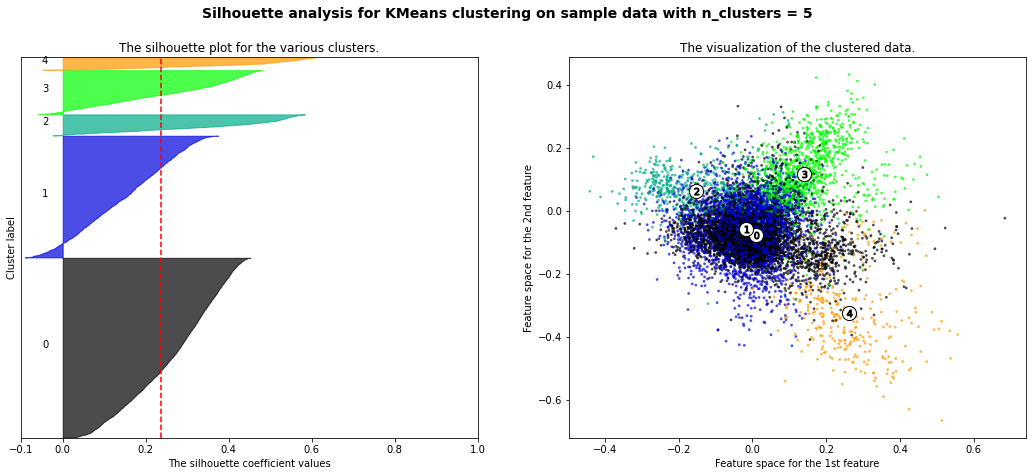

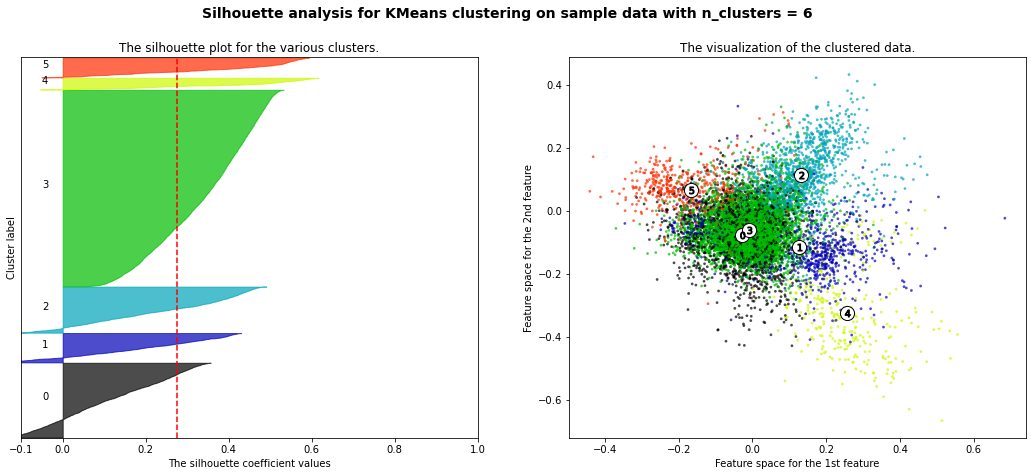

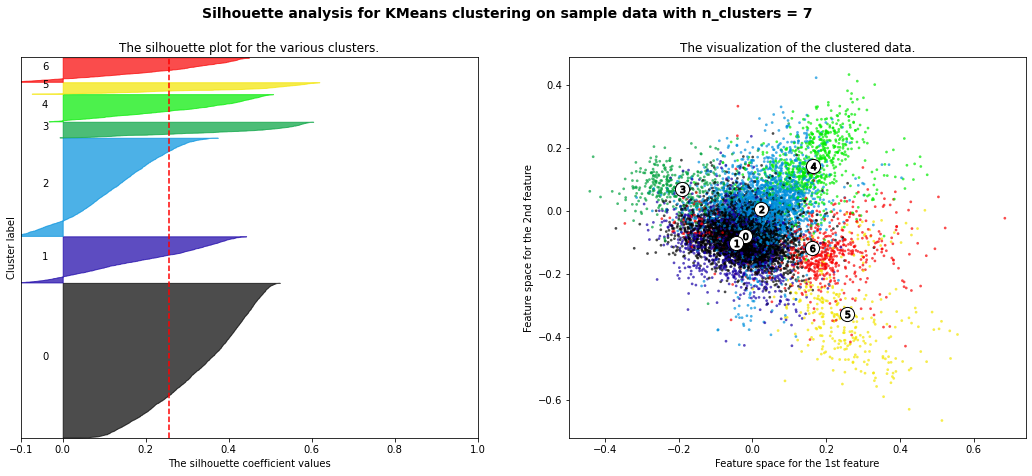

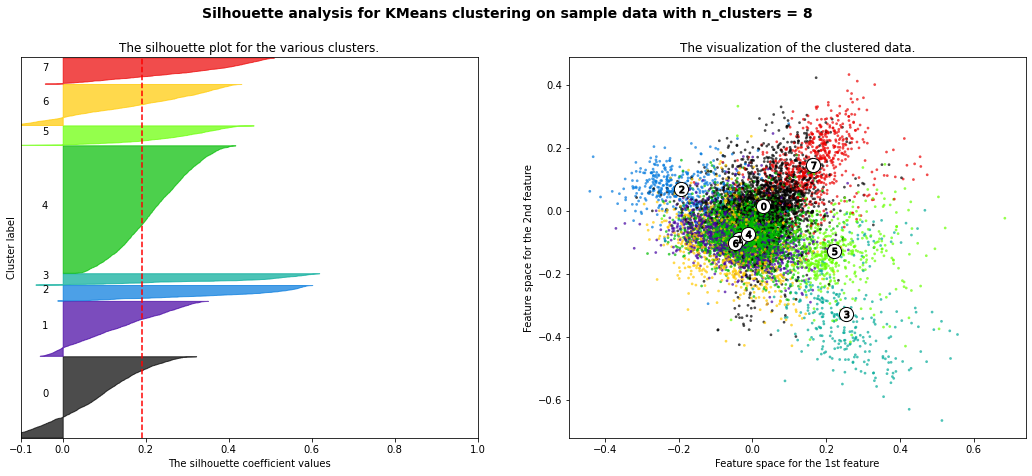

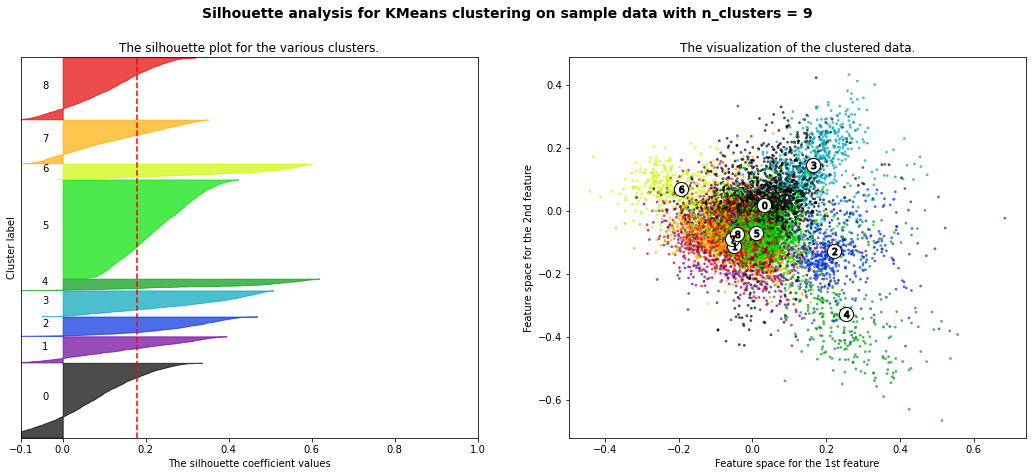

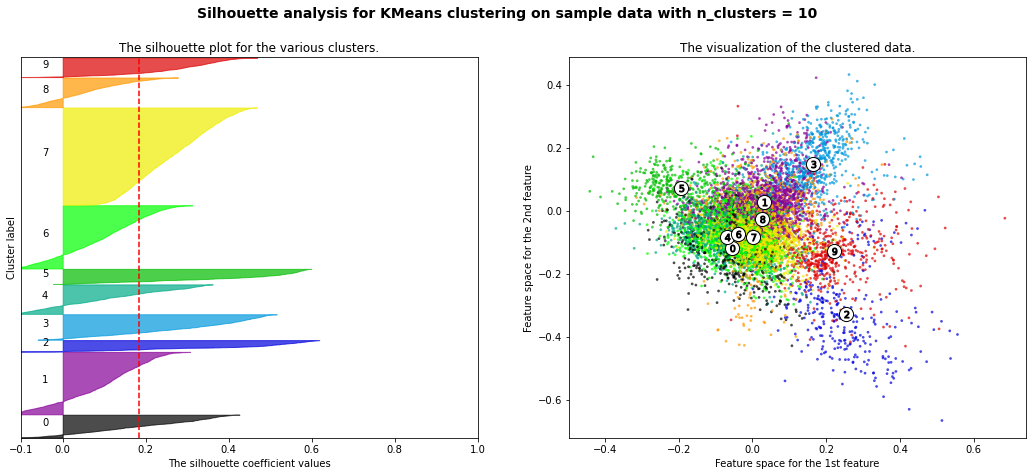

In [19]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

X = np.array(vectorized_docs)

range_n_clusters = [5, 6,7,8,9,10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(vectorized_docs)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(vectorized_docs, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(vectorized_docs, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [20]:
clustering, cluster_labels = mbkmeans_clusters(X=vectorized_docs, k=7, print_silhouette_values=True)
df_clusters = pd.DataFrame({
    "text": docs,
    "tokens": [" ".join(text) for text in tokenized_docs],
    "cluster": cluster_labels
})

C:\Users\dell\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:888: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1024 or by setting the environment variable OMP_NUM_THREADS=2
  f"MiniBatchKMeans is known to have a memory leak on "


For n_clusters = 7
Silhouette coefficient: 0.20
Inertia:8360.759419195014
Silhouette values:
    Cluster 5: Size:475 | Avg:0.34 | Min:-0.13 | Max: 0.57
    Cluster 2: Size:3640 | Avg:0.26 | Min:0.01 | Max: 0.45
    Cluster 3: Size:773 | Avg:0.25 | Min:-0.13 | Max: 0.50
    Cluster 4: Size:1161 | Avg:0.18 | Min:-0.11 | Max: 0.44
    Cluster 1: Size:2300 | Avg:0.15 | Min:-0.05 | Max: 0.34
    Cluster 6: Size:766 | Avg:0.07 | Min:-0.32 | Max: 0.31
    Cluster 0: Size:767 | Avg:0.05 | Min:-0.14 | Max: 0.26


In [21]:
from sklearn.metrics import davies_bouldin_score

In [22]:
#range_n_clusters = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

range_n_clusters = [5, 6, 7, 8, 9, 10]

silhouette_avg = []
Sum_of_squared_distances = []
db = []

In [23]:
for num_clusters in range_n_clusters:
    # initialise kmeans
    km = KMeans(n_clusters=num_clusters).fit(vectorized_docs)
    cluster_labels = km.labels_
    
    # silhouette score
    silhouette_avg.append(silhouette_score(vectorized_docs, cluster_labels))
    
    Sum_of_squared_distances.append(km.inertia_)
        
    db.append(davies_bouldin_score(vectorized_docs,cluster_labels))

In [24]:
def plot(heading, x_label, y_label, metric):
    plt.plot(range_n_clusters, metric, 'bx-')
    plt.xlabel(x_label) 
    plt.ylabel(y_label) 
    plt.title(heading)
    plt.show()

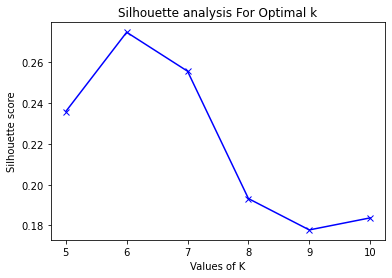

In [25]:
plot('Silhouette analysis For Optimal k', 'Values of K', 'Silhouette score', silhouette_avg)

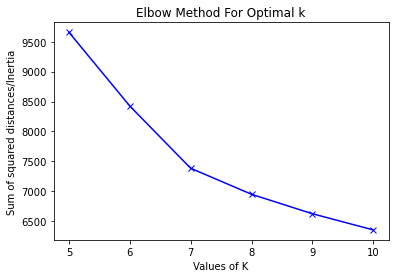

In [26]:
plot('Elbow Method For Optimal k', 'Values of K', 'Sum of squared distances/Inertia', Sum_of_squared_distances)

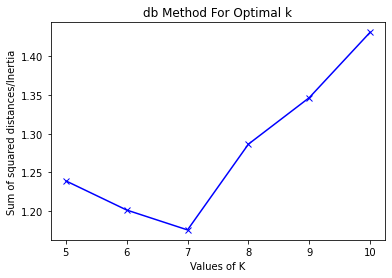

In [27]:
plot('db Method For Optimal k', 'Values of K', 'Sum of squared distances/Inertia', db)

In [28]:
clusters = []
terms_in_clusters = []
for i in range(7):
    tokens_per_cluster = ""
    most_representative = model.wv.most_similar(positive=[clustering.cluster_centers_[i]], topn=5)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")

Cluster 0: interfax terrorist berlin beirut johannesburg 
Cluster 1: prisoners planned previously resolve ties 
Cluster 2: burnley spot mansion pair provided 
Cluster 3: impeach aides ukrainian zelensky volodymyr 
Cluster 4: indiana assaulting accident identified courtroom 
Cluster 5: speech referendum labour mps jo 
Cluster 6: hurricanes grapple danger northwestern resemblance 


In [29]:
!pip install wordcloud

In [30]:
from wordcloud import WordCloud, STOPWORDS

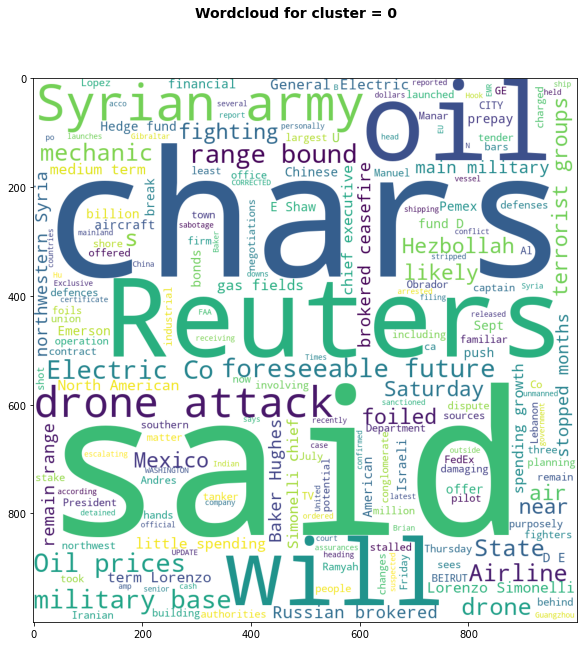

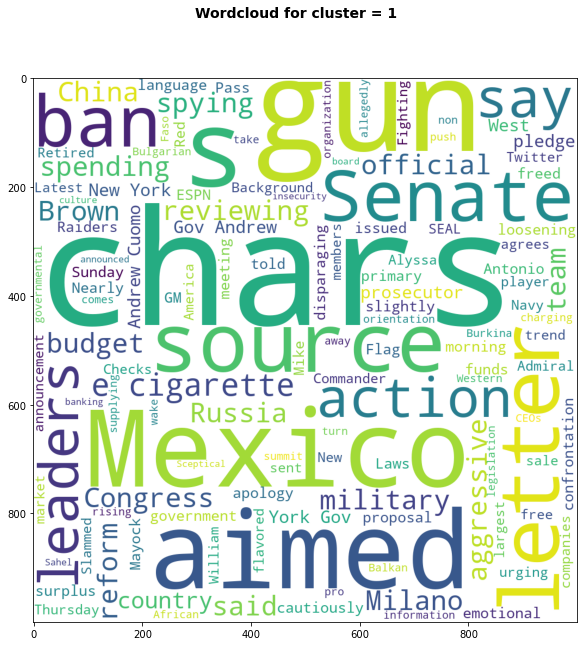

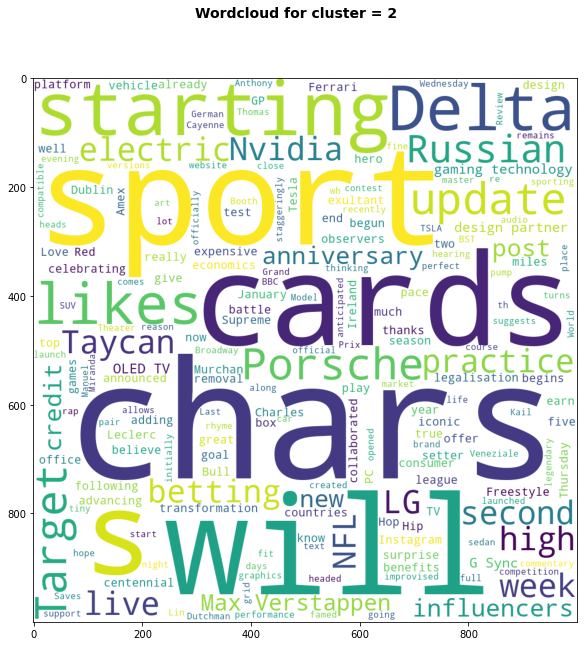

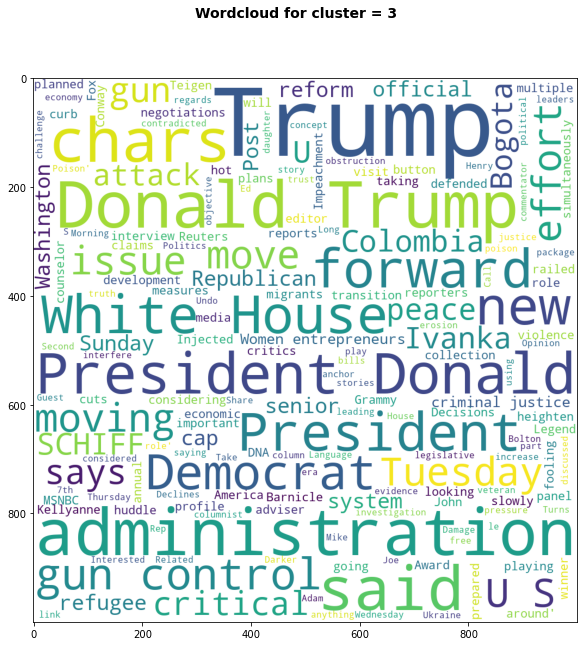

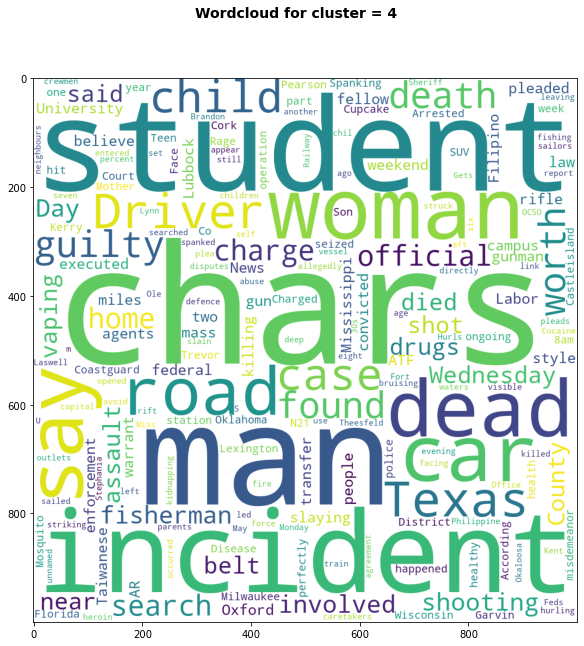

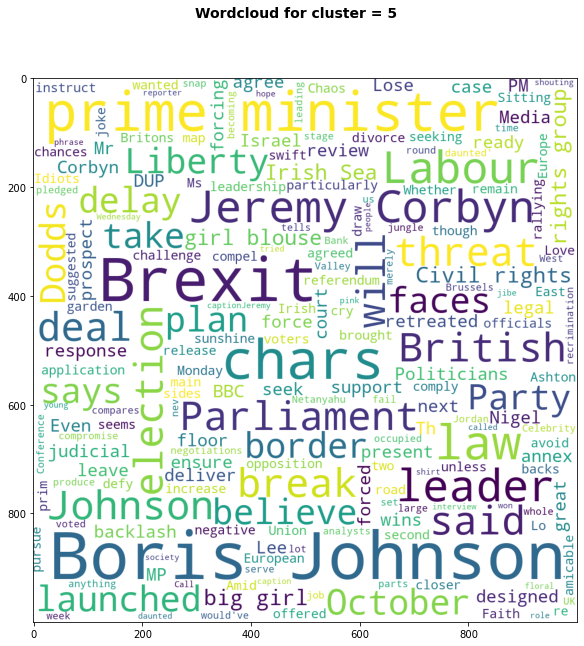

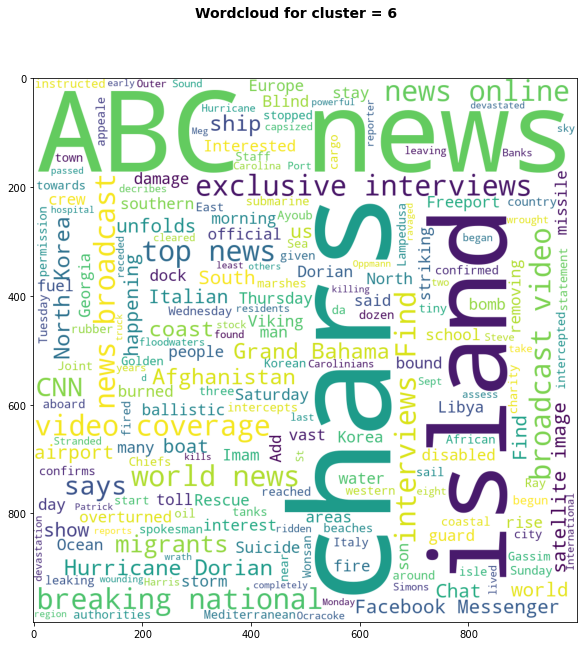

In [34]:
for i  in  range(7) :
    data = []
    test_cluster = i
    most_representative_docs = np.argsort(
        np.linalg.norm(vectorized_docs - clustering.cluster_centers_[test_cluster], axis=1)
    )
    
    for d in most_representative_docs[:10]:
        data.append(docs[d])

    data = ' '.join(data)
   
    wordcloud = WordCloud(width = 1000, height = 1000, 
            background_color ='white', 
            min_font_size = 14).generate(data) 

    plt.figure(figsize = (10, 10), facecolor = None) 
    plt.imshow(wordcloud)
    plt.suptitle(
        "Wordcloud for cluster = %d"
        % i,
        fontsize=14,
        fontweight="bold",
    )
   

In [32]:
test_cluster = 2
most_representative_docs = np.argsort(
    np.linalg.norm(vectorized_docs - clustering.cluster_centers_[test_cluster], axis=1)
)
for d in most_representative_docs[:10]:
    print(docs[d])
    print("-------------")


Russian GP: Max Verstappen tops close practice | Red Bull's Max Verstappen is a surprise pace-setter as he heads Ferrari's Charles Leclerc in second practice at the Russian GP. | Live text and audio commentary is live on the BBC Sport website from 09:55 BST
Red Bull's Max Verstappen was a surprise pace-setter as he headed Ferrari's Charles Leclerc in second practice at the Russian Grand Prix.
The Dutchman, who has a five-place grid … [+1986 chars]
-------------
‘Freestyle Love Supreme’ Review: Hip-Hop Saves the World | This exultant evening of improvised rap — created by Thomas Kail, Lin-Manuel Miranda and Anthony Veneziale — turns out to be a perfect fit for Broadway. | And just as you were thinking that life has no rhyme nor reason these days, along comes Freestyle Love Supreme to pump you full of hope.
This exultant master course in the fine art of hip-hop, which opened on Wednesday night at the Booth Theater, suggests th… [+907 chars]
-------------
In the battle of the Tesla Model 